This example demonstrates the MUSE reconstruction, including shot-to-shot phase estimation.

Author:

* Zhengguo Tan <zhengguo.tan@gmail.com>

In [1]:
import h5py
import os
import torch

import matplotlib.pyplot as plt
import numpy as np
import sigpy as sp
from sigpy.mri import muse, retro, sms

import torch.nn as nn
import torch.optim as optim

from deepdwi.models import mri

DIR = os.getcwd()

DAT_DIR = DIR.rsplit('/', 1)[0] + '/data'
print('> data directory: ', DAT_DIR)

# Switch on GPU if your GPU has more than 4 GB memory
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print('> device: ', device)

/home/atuin/b143dc/b143dc15/.conda/envs/deepdwi/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> data directory:  /home/atuin/b143dc/b143dc15/Softwares/DeepDWI/data
> device:  cpu


### load data from Zenodo

In [2]:
f = h5py.File(DAT_DIR + '/1.2mm_32-dir_R3x2_kdat_slice_000.h5', 'r')
kdat = f['kdat'][:]
MB = f['MB'][()]
N_slices = f['Slices'][()]
N_segments = f['Segments'][()]
N_Accel_PE = 3  # f['Accel_PE'][()]
f.close()

kdat = np.squeeze(kdat)  # 4 dim
kdat = np.swapaxes(kdat, -2, -3)

# # split kdat into shots
N_diff = kdat.shape[-4]
kdat_prep = []
for d in range(N_diff):
    k = retro.split_shots(kdat[d, ...], shots=N_segments)
    kdat_prep.append(k)

kdat_prep = np.array(kdat_prep)
kdat_prep = kdat_prep[..., None, :, :]  # 6 dim

N_diff, N_shot, N_coil, _, N_y, N_x = kdat_prep.shape

print(' > kdat shape: ', kdat_prep.shape)


# coil
f = h5py.File(DAT_DIR + '/1.2mm_32-dir_R3x2_coil.h5', 'r')
coil = f['coil'][:]
f.close()

print(' > coil shape: ', coil.shape)

N_coil, N_z, N_y, N_x = coil.shape

 > kdat shape:  (32, 2, 32, 1, 182, 182)
 > coil shape:  (32, 94, 182, 182)


### calculate multi-band phase shift

In [3]:
yshift = []
for b in range(MB):
    yshift.append(b / N_Accel_PE)

sms_phase = sms.get_sms_phase_shift([MB, N_y, N_x], MB=MB, yshift=yshift)

 > sms: yshift  [0.0, 0.3333333333333333]


In [4]:
slice_mb_idx = sms.map_acquire_to_ordered_slice_idx(0, N_slices, MB)

coil2 = coil[:, slice_mb_idx, :, :]

### reconstruct the 1st slice

In [5]:
import torchvision.transforms as T

acs_shape = list([N_y // 4, N_x //4])
ksp_acs = sp.resize(kdat_prep, oshape=list(kdat_prep.shape[:-2]) + acs_shape)

coils_tensor = sp.to_pytorch(coil2)
TR = T.Resize(tuple(acs_shape))
mps_acs_r = TR(coils_tensor[..., 0]).cpu().detach().numpy()
mps_acs_i = TR(coils_tensor[..., 1]).cpu().detach().numpy()
mps_acs = mps_acs_r + 1j * mps_acs_i

sms_phase_acs = sms.get_sms_phase_shift([MB] + acs_shape, MB=MB, yshift=yshift)

_, dwi_shot = muse.MuseRecon(ksp_acs, mps_acs,
                             MB=MB,
                             acs_shape=acs_shape,
                             lamda=0.01, max_iter=30,
                             yshift=yshift,
                             device=sp.Device(-1))

_, dwi_shot_phase = muse._denoising(dwi_shot, full_img_shape=[N_y, N_x])

/home/atuin/b143dc/b143dc15/.conda/envs/deepdwi/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


 > sms: yshift  [0.0, 0.3333333333333333]
 > sms: yshift  [0.0, 0.3333333333333333]
**** MUSE - ksp_acs shape  (32, 2, 32, 1, 45, 45)
**** MUSE - mps_acs shape  (32, 2, 45, 45)
>> muse on slice 00 diff 000
 > sms: yshift  [0.0, 0.3333333333333333]
  cg iter:  0; resid:      0.002780; norm:      0.018703
  cg iter:  1; resid:      0.001197; norm:      0.023136
  cg iter:  2; resid:      0.000762; norm:      0.024961
  cg iter:  3; resid:      0.000489; norm:      0.026027
  cg iter:  4; resid:      0.000378; norm:      0.026843
  cg iter:  5; resid:      0.000305; norm:      0.027514
  cg iter:  6; resid:      0.000258; norm:      0.028118
  cg iter:  7; resid:      0.000234; norm:      0.028744
  cg iter:  8; resid:      0.000205; norm:      0.029344
  cg iter:  9; resid:      0.000193; norm:      0.029978
  cg iter: 10; resid:      0.000176; norm:      0.030667
  cg iter: 11; resid:      0.000167; norm:      0.031344
  cg iter: 12; resid:      0.000162; norm:      0.032113
  cg iter: 

### Reconstruct one DWI at a time

In [6]:
coil_tensor = torch.from_numpy(coil2).to(device).type(torch.complex64)
kdat_tensor = torch.from_numpy(kdat_prep).to(device).type(torch.complex64)
shot_phase_tensor = torch.from_numpy(dwi_shot_phase).to(device).type(torch.complex64)
sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(torch.complex64)

DWI = []
for n in range(3):

    print('> Diffusion Encoding #', n)

    shot_phase_n = shot_phase_tensor[[n], ...]
    kdat_prep_n = kdat_tensor[[n], ...]

    S = mri.Sense(coil_tensor, kdat_prep_n,
                  phase_echo=shot_phase_n,
                  combine_echo=True,
                  phase_slice=sms_phase_tensor)

    print('> S ishape: ', S.ishape)
    print('> S oshape: ', S.oshape)

    x = torch.zeros(S.ishape, dtype=torch.complex64,
                    device=device,
                    requires_grad=True)

    print('> x device: ', x.device)

    lossf = nn.MSELoss(reduction='sum')
    optimizer = optim.SGD([x], lr=0.1)

    for epoch in range(50):
        fwd = S(x)
        res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

        optimizer.zero_grad()
        res.backward()
        optimizer.step()

        print('> epoch %3d loss %.12f'%(epoch, res.item()))

    DWI.append(x.cpu().detach().numpy())

DWI = np.array(DWI)

print(DWI.shape)

> Diffusion Encoding # 0
> S ishape:  [1, 1, 1, 2, 182, 182]
> S oshape:  torch.Size([1, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 0.000543790869
> epoch   1 loss 0.000465808756
> epoch   2 loss 0.000401623111
> epoch   3 loss 0.000348512578
> epoch   4 loss 0.000304336194
> epoch   5 loss 0.000267402094
> epoch   6 loss 0.000236367632
> epoch   7 loss 0.000210162543
> epoch   8 loss 0.000187929836
> epoch   9 loss 0.000168980201
> epoch  10 loss 0.000152756838
> epoch  11 loss 0.000138807838
> epoch  12 loss 0.000126764833
> epoch  13 loss 0.000116326322
> epoch  14 loss 0.000107244305
> epoch  15 loss 0.000099313955
> epoch  16 loss 0.000092365452
> epoch  17 loss 0.000086257285
> epoch  18 loss 0.000080871134
> epoch  19 loss 0.000076107623
> epoch  20 loss 0.000071882976
> epoch  21 loss 0.000068126290
> epoch  22 loss 0.000064777327
> epoch  23 loss 0.000061784718
> epoch  24 loss 0.000059104517
> epoch  25 loss 0.000056698958
> epoch  26 loss 0.000054535551
> epoch  

### Jointly reconstruct all DWIs

In [7]:
coil_tensor = torch.from_numpy(coil2).to(device).type(torch.complex64)
kdat_tensor = torch.from_numpy(kdat_prep).to(device).type(torch.complex64)
shot_phase_tensor = torch.from_numpy(dwi_shot_phase).to(device).type(torch.complex64)
sms_phase_tensor = torch.from_numpy(sms_phase).to(device).type(torch.complex64)

S = mri.Sense(coil_tensor, kdat_tensor,
              phase_echo=shot_phase_tensor,
              combine_echo=True,
              phase_slice=sms_phase_tensor)

print('> S ishape: ', S.ishape)
print('> S oshape: ', S.oshape)

x = torch.zeros(S.ishape, dtype=torch.complex64,
                device=device,
                requires_grad=True)

print('> x device: ', x.device)

lossf = nn.MSELoss(reduction='sum')
optimizer = optim.SGD([x], lr=0.1)

for epoch in range(50):
    fwd = S(x)
    res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %.12f'%(epoch, res.item()))

print('> x shape: ', x.shape)

> S ishape:  [32, 1, 1, 2, 182, 182]
> S oshape:  torch.Size([32, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 0.004759669770
> epoch   1 loss 0.004128590226
> epoch   2 loss 0.003620518139
> epoch   3 loss 0.003208328970
> epoch   4 loss 0.002871440724
> epoch   5 loss 0.002594123594
> epoch   6 loss 0.002364271320
> epoch   7 loss 0.002172501991
> epoch   8 loss 0.002011495410
> epoch   9 loss 0.001875501359
> epoch  10 loss 0.001759973471
> epoch  11 loss 0.001661294838
> epoch  12 loss 0.001576569513
> epoch  13 loss 0.001503464184
> epoch  14 loss 0.001440089545
> epoch  15 loss 0.001384905423
> epoch  16 loss 0.001336649992
> epoch  17 loss 0.001294284128
> epoch  18 loss 0.001256947522
> epoch  19 loss 0.001223924453
> epoch  20 loss 0.001194616314
> epoch  21 loss 0.001168520655
> epoch  22 loss 0.001145213610
> epoch  23 loss 0.001124335919
> epoch  24 loss 0.001105582342
> epoch  25 loss 0.001088691643
> epoch  26 loss 0.001073440537
> epoch  27 loss 0.001059636590


### display results

(3, 182, 182)


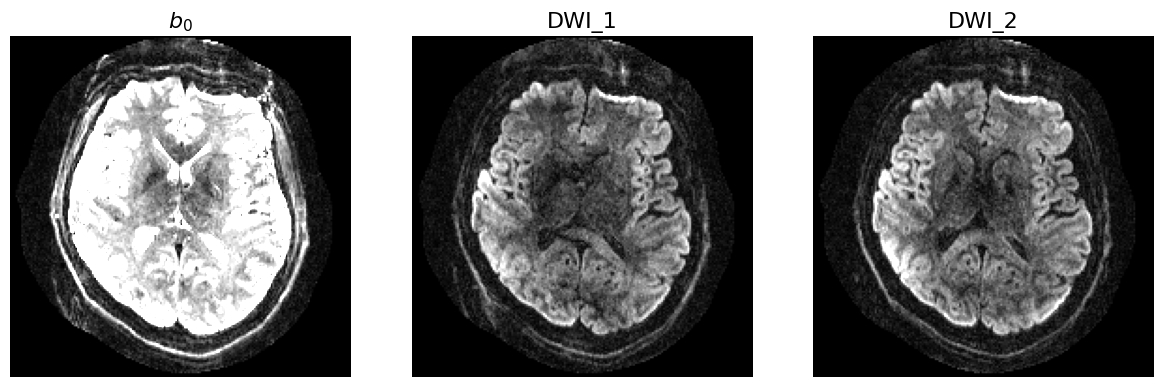

In [8]:
fontsize = 16

DWI_s1 = np.squeeze(DWI)
DWI_s1 = DWI_s1[..., 1, :, :]

print(DWI_s1.shape)

vmax = np.amax(abs(DWI_s1)) * 0.15

fig, ax = plt.subplots(1, 3, figsize=(3*4 + 0.2, 4))
fig.tight_layout()

for b in range(3):
    ax[b].imshow(abs(np.flip(DWI_s1[b], axis=(-2, -1))), cmap='gray', vmax=vmax)
    ax[b].set_axis_off()
    if b == 0:
        ax[b].set_title('$b_0$', fontsize=fontsize)
    else:
        ax[b].set_title('DWI_' + str(b), fontsize=fontsize)

plt.show()

(3, 182, 182)


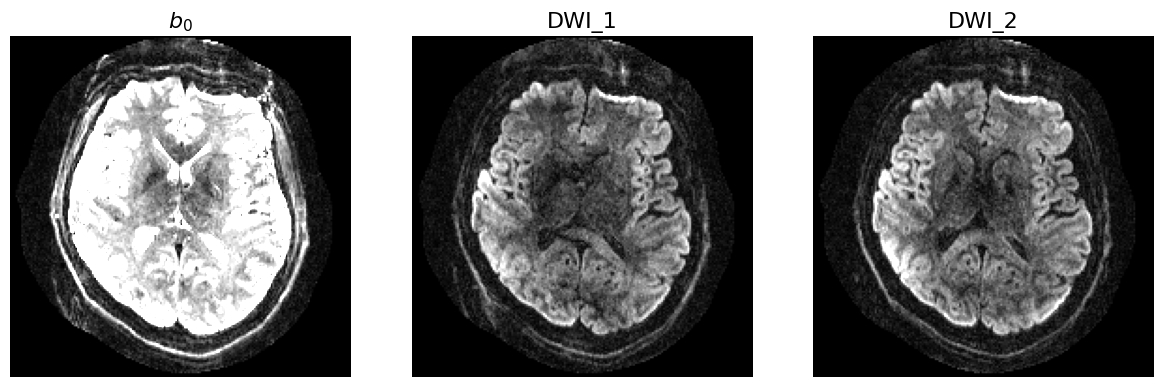

In [9]:
fontsize = 16

xjt = x.clone().cpu().detach().numpy()

xjt_s1 = np.squeeze(DWI)
xjt_s1 = xjt_s1[..., 1, :, :]

print(xjt_s1.shape)

vmax = np.amax(abs(xjt_s1)) * 0.15

fig, ax = plt.subplots(1, 3, figsize=(3*4 + 0.2, 4))
fig.tight_layout()

for b in range(3):
    ax[b].imshow(abs(np.flip(xjt_s1[b], axis=(-2, -1))), cmap='gray', vmax=vmax)
    ax[b].set_axis_off()
    if b == 0:
        ax[b].set_title('$b_0$', fontsize=fontsize)
    else:
        ax[b].set_title('DWI_' + str(b), fontsize=fontsize)

plt.show()

### Decoder

In [10]:
import torch.nn as nn

class VAE(nn.Module):
    """
    Variational AutoEncoder
    """
    def __init__(self,
                 input_features=81,
                 latent_features=15,
                 depth=4):

        super(VAE, self).__init__()

        encoder_module = []
        decoder_module = []

        encoder_features = torch.linspace(start=input_features,
                                          end=latent_features,
                                          steps=depth+1).type(torch.int64)
        decoder_features = torch.flip(encoder_features, dims=(0, ))

        # encoder
        for d in range(depth - 1):
            encoder_module.append(nn.Linear(encoder_features[d], encoder_features[d+1]))
            encoder_module.append(nn.ReLU(True))

        self.encoder_seq = nn.Sequential(*encoder_module)

        # latent layer
        self.fc1 = nn.Linear(encoder_features[depth-1], encoder_features[depth])
        self.fc2 = nn.Linear(encoder_features[depth-1], encoder_features[depth])

        # decoder
        for d in range(depth):
            decoder_module.append(nn.Linear(decoder_features[d], decoder_features[d+1]))
            if d < (depth - 1):
                decoder_module.append(nn.ReLU(True))
            else: # last layer
                decoder_module.append(nn.Sigmoid())

        self.decoder_seq = nn.Sequential(*decoder_module)

    def encode(self, x):
        features = self.encoder_seq(x)
        return self.fc1(features), self.fc2(features)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder_seq(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [11]:
import torch

model = VAE(input_features=32, latent_features=7)

model.load_state_dict(torch.load(DAT_DIR + '/train_VAE_Latent07final.pt'))

model.to(device)

temp = model.decode(torch.zeros([100, 7], device=device))

print(temp.shape)

FileNotFoundError: [Errno 2] No such file or directory: '/home/atuin/b143dc/b143dc15/Softwares/DeepDWI/data/train_VAE_Latent07final.pt'

In [ ]:


S = mri.Sense(coil_tensor, kdat_tensor,
                  phase_echo=shot_phase_tensor,
                  combine_echo=True,
                  phase_slice=sms_phase_tensor,
                  basis=model)

print(S.ishape)
print(S.oshape)


x = torch.zeros(S.ishape, dtype=torch.float32,
                device=device,
                requires_grad=True)

print('> x device: ', x.device)

temp = S(x)


lossf = nn.MSELoss(reduction='sum')
optimizer = optim.SGD([x], lr=0.1)

for epoch in range(500):
    fwd = S(x)
    res = lossf(torch.view_as_real(fwd), torch.view_as_real(S.y))

    optimizer.zero_grad()
    res.backward()
    optimizer.step()

    print('> epoch %3d loss %.12f'%(epoch, res.item()))


[7, 1, 1, 2, 182, 182]
torch.Size([32, 2, 32, 1, 182, 182])
> x device:  cpu
> epoch   0 loss 40906.929687500000
> epoch   1 loss 40756.867187500000
> epoch   2 loss 40610.406250000000
> epoch   3 loss 40471.050781250000
> epoch   4 loss 40336.894531250000
> epoch   5 loss 40192.851562500000
> epoch   6 loss 40002.953125000000
> epoch   7 loss 39799.250000000000
> epoch   8 loss 39591.593750000000
> epoch   9 loss 39367.960937500000
> epoch  10 loss 39112.246093750000
> epoch  11 loss 38831.781250000000
> epoch  12 loss 38544.066406250000
> epoch  13 loss 38259.046875000000
> epoch  14 loss 37980.605468750000
> epoch  15 loss 37708.695312500000
> epoch  16 loss 37442.238281250000
> epoch  17 loss 37179.750000000000
> epoch  18 loss 36919.699218750000
> epoch  19 loss 36660.941406250000
> epoch  20 loss 36402.980468750000
> epoch  21 loss 36144.957031250000
> epoch  22 loss 35886.121093750000
> epoch  23 loss 35626.652343750000
> epoch  24 loss 35367.929687500000
> epoch  25 loss 35112.

KeyboardInterrupt: 

torch.Size([7, 1, 1, 2, 182, 182])


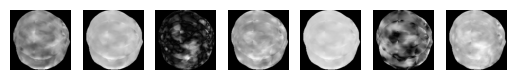

In [ ]:
print(x.shape)

latents = x.detach().numpy()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 7)

for n in range(7):

    ax[n].imshow(abs(latents[n, 0, 0, 1]), cmap='gray')
    ax[n].set_axis_off()

plt.show()